# Preprocessing

## JSON $\rightarrow$ Pandas
Turning metadatas json into useful and readable pandas dataframes

in order to make this script work you need to have the dataset in the working wolder such as:
```
>> fds-2022-final-project
    >> ...
    >> og_dataset
        >> slices.json
        >> splits
            >> train/
            >> dev/
            >> test/
```

In [30]:
import json
import os
import numpy as np
import pandas as pd

metadata_file = 'og_dataset/slices.geojson'
train_folder = 'og_dataset/splits/train/'
dev_folder   = 'og_dataset/splits/dev/'
test_folder  = 'og_dataset/splits/test/'

We first import the json file, and take only the information regarding all the patches, while adding to it the center of the longitude and latitude of the patch

In [31]:
with open(metadata_file) as f:
    d = json.load(f)
patches = d['features']
patches = [{
    **p['properties'], 
     'lng':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[0],
     'lat':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[1]
    } for p in patches]
patches[:2]

[{'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_000.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_000.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 77.38898468017578,
  'lng': 333795.9649122807,
  'lat': 3572176.06391926},
 {'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_001.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_001.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 133.6044158935547,
  'lng': 348977.8947368421,
  'lat': 3572176.06391926}]

Now we port the dataset into pandas and clean it, by:
- taking the number of the original img it came from
- taking the slice number
- using the 2 aforemwntioned features as index
- drop the name of the original file it came from
- combine (sum) the mean of layer 0 and 1 of the mask together
- drop the mean of layer 0 and 1 of the mask (since those are now combined in `mask_mean`)
- rename the `mask_mean_2` as `china`, since it's the percentage of china represented in the image

In [67]:
metadata = pd.DataFrame(patches)
files_columns = ['img_source','mask_source','img_slice','mask_slice']
metadata[files_columns] = metadata[files_columns].applymap(lambda x: x.split('/')[-1])
metadata['src'] = metadata.img_slice.map(lambda s: s.split('_')[1])
metadata['slice_num'] = metadata.img_slice.map(lambda s: s.split('_')[-1][:3])
metadata.set_index(['src', 'slice_num'], inplace=True)
metadata.drop(columns=['img_source', 'mask_source'], inplace=True)

metadata.head()

img_slice            mask_slice  mask_mean_0  \
src slice_num                                                           
0   000        slice_0_img_000.npy  slice_0_mask_000.npy          0.0   
    001        slice_0_img_001.npy  slice_0_mask_001.npy          0.0   
    002        slice_0_img_002.npy  slice_0_mask_002.npy          0.0   
    003        slice_0_img_003.npy  slice_0_mask_003.npy          0.0   
    004        slice_0_img_004.npy  slice_0_mask_004.npy          0.0   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
0   000                0.0          0.0   77.388985  333795.964912   
    001                0.0          0.0  133.604416  348977.894737   
    002                0.0          0.0   94.324028  364159.824561   
    003                0.0          0.0  189.766983  379341.754386   
    004                0.0          0.0  198.229507  394523.684211   

                        lat  
src slice_num                
0   000        3.572176e+06  
    001        3.572176e+06  
    002        3.572176e+06  
    003        3.572176e+06  
    004        3.572176e+06

Then we take the list of all the slice files for each folder

In [68]:
def list_files(folder):
    list_of_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            list_of_files.append(file)
    return list_of_files

train_splits = list_files(train_folder)
dev_splits = list_files(dev_folder)
test_splits = list_files(test_folder)

train_splits[:3]

['slice_12_mask_125.npy', 'slice_20_mask_043.npy', 'slice_10_img_186.npy']

And finally we partition the metadata in 3 different datasets

In [69]:
def partition_metadata(metadata, splits, folder = ''):
    # takes only the rows corresponding to those in the splits
    res = metadata[metadata.img_slice.isin( splits )].copy()
    # then adds the 
    res.img_slice = folder + res.img_slice
    res.mask_slice = folder + res.mask_slice
    return res

test_data = partition_metadata(metadata, test_splits, folder=test_folder)
dev_data = partition_metadata(metadata, dev_splits, folder=dev_folder)
train_data = partition_metadata(metadata, train_splits, folder=train_folder)

train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  
src slice_num                
1   150        4.200787e+06  
    165        4.215970e+06  
    168        4.215970e+06  
    185        4.231152e+06  
    186        4.231152e+06

In [35]:
test_data.to_csv('dataset/test_data.csv')
train_data.to_csv('dataset/train_data.csv')
dev_data.to_csv('dataset/dev_data.csv')

Now, to load a dataset:

In [36]:
pd.read_csv('dataset/train_data.csv', index_col=['src','slice_num']).head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice     china  \
src slice_num                                                           
1   150        og_dataset/splits/train/slice_1_mask_150.npy  0.000595   
    165        og_dataset/splits/train/slice_1_mask_165.npy  0.000000   
    168        og_dataset/splits/train/slice_1_mask_168.npy  0.000000   
    185        og_dataset/splits/train/slice_1_mask_185.npy  0.000000   
    186        og_dataset/splits/train/slice_1_mask_186.npy  0.000023   

                 img_mean            lng           lat  mask_mean  
src slice_num                                                      
1   150        382.686157  445035.967865  4.200787e+06   0.370186  
    165        370.955048  445035.967865  4.215970e+06   0.216293  
    168        437.918457  490581.775057  4.215970e+06   0.322586  
    185        448.878815  520945.646519  4.231152e+06   0.383347  
    186        349.251465  536127.582249  4.231152e+06   0.274628

## Extract infos from metadata
We now want to get some informations out of the JSONs we just worked with

### China percentage

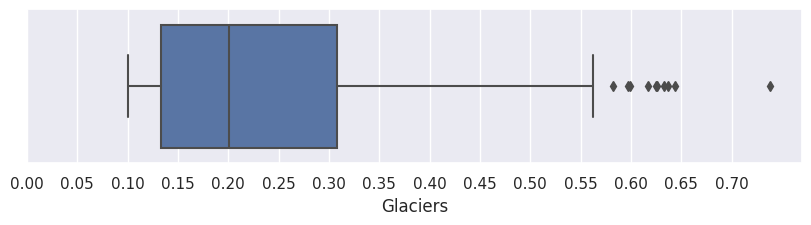

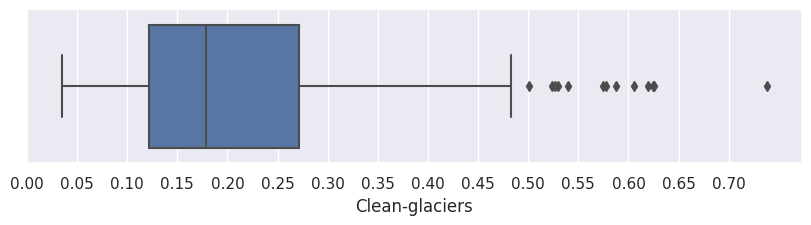

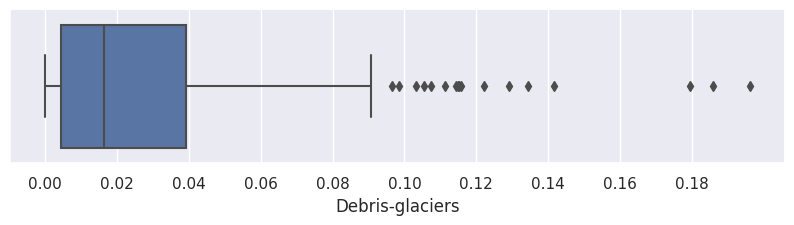

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(10, 2)})

sns.boxplot(data=train_data, x='mask_mean_0')
plt.xticks(np.arange(0,train_data.mask_mean_0.max(), .05))
plt.xlabel('Glaciers')
plt.show()

sns.boxplot(data=train_data, x='mask_mean_1')
plt.xticks(np.arange(0,train_data.mask_mean_1.max(), .05))
plt.xlabel('Clean-glaciers')
plt.show()

sns.boxplot(data=train_data, x='mask_mean_2')
plt.xticks(np.arange(0,train_data.mask_mean_2.max(), .02))
plt.xlabel('Debris-glaciers')
plt.show()

We can see that almost all of the values are in the range $(0, 0.04)$ and that only few outliers are above $0.1$.

## Create new Masks

We now want to read all the masks, which are $512 \times 512 \times 3$ `np.array` and we want to sum just the first 2 layers between themselves, as the layers of the array represent:
1. Clean-ice Glacier
2. Debris covered glacier
3. Is in china

We first load each matrix, but it appears some of the files are corrupted:

In [79]:
def load(file):
    try:
        return np.load(file)
    except:
        return pd.NA
    
test_data['np_mask'] = test_data.mask_slice.apply(lambda x: load(x))
train_data['np_mask'] = train_data.mask_slice.apply(lambda x: load(x))
dev_data['np_mask'] = dev_data.mask_slice.apply(lambda x: load(x))

Then we get the percentage of HKH in the patch, this differs from china for some reason

In [96]:
test_data['debris_mean'] = test_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')
dev_data['debris_mean'] = dev_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')
train_data['debris_mean'] = train_data.np_mask.map(lambda m: m[:,:,1].mean(), na_action='ignore')

Then we combine together the first 2 layers of the masks:

In [98]:
test_data['clean_mean'] = test_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')
dev_data['clean_mean'] = dev_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')
train_data['clean_mean'] = train_data.np_mask.map(lambda m: m[:,:,0].mean(), na_action='ignore')

Finally we compute the mean of each of the masks:

In [101]:
test_data['glacier_perc'] = test_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
train_data['glacier_perc'] = train_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
dev_data['glacier_perc'] = dev_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')

train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice  mask_mean_0  \
src slice_num                                                              
1   150        og_dataset/splits/train/slice_1_mask_150.npy     0.185390   
    165        og_dataset/splits/train/slice_1_mask_165.npy     0.108147   
    168        og_dataset/splits/train/slice_1_mask_168.npy     0.161293   
    185        og_dataset/splits/train/slice_1_mask_185.npy     0.191673   
    186        og_dataset/splits/train/slice_1_mask_186.npy     0.137325   

               mask_mean_1  mask_mean_2    img_mean            lng  \
src slice_num                                                        
1   150           0.184795     0.000595  382.686157  445035.967865   
    165           0.108147     0.000000  370.955048  445035.967865   
    168           0.161293     0.000000  437.918457  490581.775057   
    185           0.191673     0.000000  448.878815  520945.646519   
    186           0.137302     0.000023  349.251465  536127.582249   

                        lat  \
src slice_num                 
1   150        4.200787e+06   
    165        4.215970e+06   
    168        4.215970e+06   
    185        4.231152e+06   
    186        4.231152e+06   

                                                         np_mask glacier_perc  \
src slice_num                                                                   
1   150        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...      0.18539   
    165        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...     0.108147   
    168        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...     0.161293   
    185        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...     0.191673   
    186        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...     0.137325   

              clean_mean debris_mean  
src slice_num                         
1   150         0.184795    0.000595  
    165         0.108147         0.0  
    168         0.161293         0.0  
    185         0.191673         0.0  
    186         0.137302    0.000023

We notice that strangely the debris_mean and the clean_mean _almost_ add up to 1

### Glaciers percentage
Finally we can see the distribution of percentages of glaciers

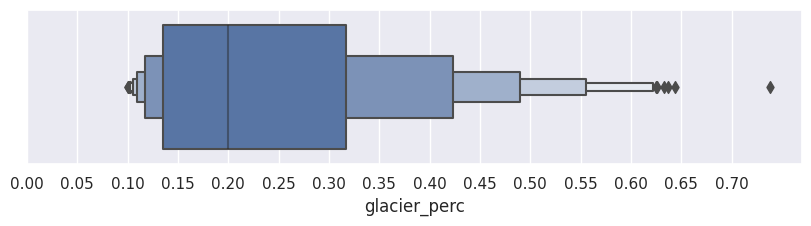

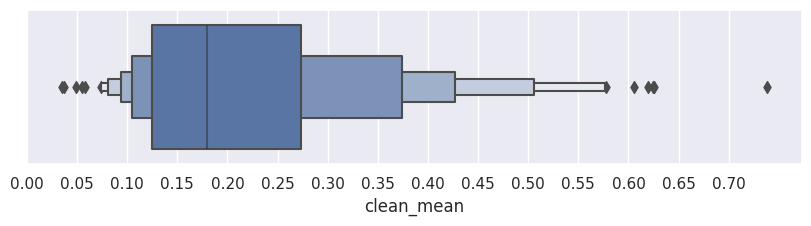

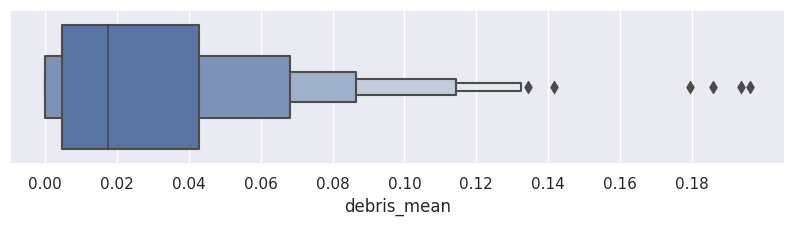

In [103]:
sns.boxenplot(data=train_data.dropna(), x='glacier_perc' )
plt.xticks(np.arange(0,train_data.glacier_perc.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='clean_mean' )
plt.xticks(np.arange(0,train_data.clean_mean.max(),0.05))
plt.show()

sns.boxenplot(data=train_data.dropna(), x='debris_mean' )
plt.xticks(np.arange(0,train_data.debris_mean.max(),0.02))
plt.show()

Aside from the data being a little strange since they are sometimes bigger than 1, I would say that the optimal choice for the **threshold** should be $0.2$.

In [ ]:
## Save the new np masks, unnecesary
# dev_data\
#     .reset_index()\
#     .apply(lambda r: 
#             np.save(f'dataset/masks/dev/slice_{r.src}_mask_{r.slice_num}.npy', r.np_mask),
#            axis=1)
# ;

### Creating Label for images based on our threshold value of 0.2 and Masks of the image.

> Those images with pixels less than 20% are identified as non-glacier image and more than 20% as glacier image

In [61]:
THRESHOLD = 0.2
train_data['label'] = train_data.mask_mean.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
test_data['label']  = test_data.mask_mean.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
dev_data['label']   = dev_data.mask_mean.map(lambda x: 1 if x > THRESHOLD else 0, na_action='ignore')
train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice     china  \
src slice_num                                                           
1   150        og_dataset/splits/train/slice_1_mask_150.npy  0.000595   
    165        og_dataset/splits/train/slice_1_mask_165.npy  0.000000   
    168        og_dataset/splits/train/slice_1_mask_168.npy  0.000000   
    185        og_dataset/splits/train/slice_1_mask_185.npy  0.000000   
    186        og_dataset/splits/train/slice_1_mask_186.npy  0.000023   

                 img_mean            lng           lat mask_mean  \
src slice_num                                                      
1   150        382.686157  445035.967865  4.200787e+06  0.184795   
    165        370.955048  445035.967865  4.215970e+06  0.108147   
    168        437.918457  490581.775057  4.215970e+06  0.161293   
    185        448.878815  520945.646519  4.231152e+06  0.191673   
    186        349.251465  536127.582249  4.231152e+06  0.137302   

                                                         np_mask debris_mean  \
src slice_num                                                                  
1   150        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...     0.81461   
    165        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.891853   
    168        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.838707   
    185        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.808327   
    186        [[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ...    0.862675   

              clean_mean label  
src slice_num                   
1   150         0.000595     0  
    165              0.0     0  
    168              0.0     0  
    185              0.0     0  
    186         0.000023     0

### Checking Counts for different classes for each set

In [62]:
train_data.label.value_counts()

0    197
1    149
Name: label, dtype: int64

#### We see that choosing threshold of  *20%* of number of pixels identified as snow gives us a balanced training dataset

In [63]:
test_data.label.value_counts()

1    50
0    49
Name: label, dtype: int64

In [64]:
dev_data.label.value_counts()

1    30
0    25
Name: label, dtype: int64

#### Validation set also seems to be more or less balanced (60%,40% split between the two class)

In [66]:
test_data.to_csv('dataset/test_data.csv')
train_data.to_csv('dataset/train_data.csv')
dev_data.to_csv('dataset/dev_data.csv')